In [1]:
import os,tqdm
import cPickle,json
import numpy as np
prefix = '/ivi/ilps/personal/xli/knowledge_intent/data/'
session_data = json.load(open(prefix + 'session.json'))
qdid2text_dict = json.load(open(prefix + 'qdid2text_dict.json'))
(qid2eid,did2eid) = cPickle.load(open(prefix + 'qdid2eid-xlore.pkl'))

print 'loaded'
'''
session_data = [{
'sid':
'qids':[q1,q2,...],
'docs':[[(d1,c1),(d2,c2),...],[]]
},]
'''


loaded


"\nsession_data = [{\n'sid':\n'qids':[q1,q2,...],\n'docs':[[(d1,c1),(d2,c2),...],[]]\n},]\n"

In [5]:
ent_graph = cPickle.load(open(prefix + '../entity/ent-graph.pkl'))
print '#nodes: ',  ent_graph.number_of_nodes()
print '#edges: ',  ent_graph.number_of_edges()

#nodes:  2136189
#edges:  7556097


In [12]:
count = 0;total = 0
query_nodes_list = set()
nodes_list = set()
for qid,ent_list in tqdm.tqdm(qid2eid.iteritems()):
    total += len(ent_list)
    nodes_list.update(ent_list)
    query_nodes_list.update(ent_list)
    for eid in ent_list:
        if eid in ent_graph:
            count += 1

for qid,ent_list in tqdm.tqdm(did2eid.iteritems()):
    total += len(ent_list)
    nodes_list.update(ent_list)
    for eid in ent_list:
        if eid in ent_graph:
            count += 1
           
print 'Count: ',count
print 'Total: ', total
print 'Cover: ', float(count)/ total
print 'Query size: ', len(query_nodes_list)
print 'size: ', len(nodes_list)

'''
node_file = open('nodes.txt','w')
for node in nodes_list:
    print >> node_file, node
'''
        


0it [00:00, ?it/s]


NameError: name 'ent_graph' is not defined

In [3]:
%matplotlib inline
import networkx as nx
import collections
import matplotlib.pyplot as plt
import numpy as np

print nx.info(ent_graph)
def plot_degree_dist(G):
    #degrees = [G.degree(n) for n in G.nodes()]
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    count = 0;mid = 2000
    
    for d in deg:
        if d > mid:         
            count += 1
            
    print count
    fig, ax = plt.subplots()
    cnt = np.log(cnt)
    plt.bar(deg, cnt, color='b')
    
    plt.title("Degree Histogram")
    plt.ylabel("Log of Count")
    plt.xlabel("Degree")
    
    ax.set_xlim(0,mid)
    #ax.set_ylim(0,2000)
    #ax.set_xticks([d + 0.4 for d in deg])
    #ax.set_xticklabels(deg)
    
    plt.show()
    
plot_degree_dist(ent_graph)    

NameError: name 'ent_graph' is not defined

In [2]:
#building sparse matrix for 
big_degree_neigb_dict = {}
big_degree_threshold = 200

error = 0
def collect_neigbs(node,cur,step,new_neibs):
    if cur >= step:
        return []
    #print node,ent_graph.degree(node)
    if node not in ent_graph:
        global error
        error += 1
        return []
    neibs = [nid for nid in ent_graph.neighbors(node)][:]
    #print len(neibs)  
    for n in neibs:
        if n in new_neibs:
            continue
        neis = collect_neigbs(n,cur+1,step,new_neibs)
        new_neibs.update(neis)
    new_neibs.update(neibs)
    return new_neibs


neib_dict = set()
max_step = 2

nodes_exits = set()
'''
if os.path.exists('./nodes_neib_set.pkl'):
    nodes_exits = cPickle.load(open('./nodes_neib_set.pkl'))
    neib_dict = cPickle.load(open('%s%s%d%s' % (prefix,'neig_dict_',max_step,'.pkl')))
'''
i = 0
for node in tqdm.tqdm(list(query_nodes_list)[:1]):
    if node in nodes_exits:
        continue
    new_neibs = set()
    neibs = collect_neigbs(node,0,max_step,new_neibs)
    for n in neibs:
        if (node,n) not in neib_dict or (n,node) not in neib_dict and n in nodes_list:
            neib_dict.add((node,n))
    i += 1
    nodes_exits.add(node)
    '''
    if (i + 1) % 100 == 0:
        cPickle.dump(nodes_exits, open('./nodes_neib_set.pkl','w'))
        cPickle.dump(neib_dict,open('%s%s%d%s' % (prefix,'neig_dict_',max_step,'.pkl'), 'w'))
    '''

print 'Error: ', error
print ('#neig_size: ', len(neib_dict))
prefix = '/ivi/ilps/personal/xli/knowledge_intent/data/'
#cPickle.dump(nodes_exits, open('./nodes_neib_set.pkl','w'))
#cPickle.dump(neib_dict,open('%s%s%d%s' % (prefix,'neig_dict_',max_step,'.pkl'), 'w'))

NameError: name 'query_nodes_list' is not defined

In [2]:
import numpy as np
import pandas as pd

#system_df.assign()
def session_calculation(cal_function,filter_click=False):
    match_ratio_ranks = [[] for i in range(10)]
    for session in tqdm.tqdm(session_data[:]):
        qids = session['qids']
        docs = session['docs']
        for qid,dids in zip(qids,docs):
            qid_entlist = qid2eid[qid]
            q_size = len(qid_entlist)
            #print dids
            for pos,(did,click) in enumerate(dids):
                #print 'pos: ',pos
                if filter_click and click == 0:
                    continue
                did_entlist = did2eid[did]
                d_size = len(qid_entlist)
                match = cal_function(qid_entlist,did_entlist)
                match_ratio_ranks[pos].append(match)
    return match_ratio_ranks


In [4]:
class PDtable:
    '''
    .add(data, “colname”)
    .to_pandas
    '''
    def __init__(self):
        self.column_datas = {}
        self.column_names = []

    def add(self, data_list, colname):
        if colname not in self.column_datas:
            #self.column_datas[colname] = []
            self.column_names.append(colname)
        self.column_datas[colname] = data_list

    def to_pandas(self):
        return pd.DataFrame(self.column_datas)[self.column_names]

def add_to_df(table,rank_data,name):
    for i,data_list in enumerate(rank_data):
        col_name = name + '_' + str(i)
        table.add(data_list,col_name)
        
system_table = PDtable()    

In [3]:
import scipy.stats as stats
def getExactMatchRatio(qid_entlist,did_entlist):
    did_entlist = set(did_entlist)
    match = 0;total = 1
    for ent in did_entlist:
        if ent in qid_entlist:
            match += 1
        total += 1
    return float(match) / total 

def getBinaryMatch(qid_entlist,did_entlist):
    did_entlist = set(did_entlist)
    match = 0;total = 0
    for ent in qid_entlist:
        if ent in did_entlist:
            return 1
    return 0

def printRanks(match_ratio_ranks):
    avgs = []
    for pos in range(len(match_ratio_ranks)):
        print 'Position: ',pos
        print 'Total size: ', len(match_ratio_ranks[pos])
        print 'Match rate: ', np.mean(match_ratio_ranks[pos])
        avgs.append(np.mean(match_ratio_ranks[pos]))
        if pos > 0:
            stat_val, p_val = stats.ttest_ind(match_ratio_ranks[0], match_ratio_ranks[pos])
            print ('Two-sample t-statistic D = %6.3f, p-value = %6.4f' % (stat_val, p_val))
    return avgs

In [5]:
Exactmatch_ratio_ranks = session_calculation(getExactMatchRatio)
#add_to_df(system_table, Exactmatch_ratio_ranks, 'ExactMatchRatio')
avg_list = printRanks(Exactmatch_ratio_ranks)
system_table.add(avg_list,'ExactMatchRatio')

100%|██████████| 89737/89737 [00:05<00:00, 15711.55it/s]


Position:  0
Total size:  231142
Match rate:  0.22058402771168079
Position:  1
Total size:  231142
Match rate:  0.2021509144450886
Two-sample t-statistic D = 29.743, p-value = 0.0000
Position:  2
Total size:  231141
Match rate:  0.21362710784038028
Two-sample t-statistic D = 11.127, p-value = 0.0000
Position:  3
Total size:  231125
Match rate:  0.22140594916170903
Two-sample t-statistic D = -1.300, p-value = 0.1937
Position:  4
Total size:  231068
Match rate:  0.178019385346882
Two-sample t-statistic D = 69.022, p-value = 0.0000
Position:  5
Total size:  230762
Match rate:  0.15553058995848532
Two-sample t-statistic D = 106.247, p-value = 0.0000
Position:  6
Total size:  229758
Match rate:  0.16345858105775063
Two-sample t-statistic D = 93.211, p-value = 0.0000
Position:  7
Total size:  226711
Match rate:  0.1825160667104816
Two-sample t-statistic D = 61.727, p-value = 0.0000
Position:  8
Total size:  212893
Match rate:  0.19635262784591317
Two-sample t-statistic D = 38.738, p-value = 

In [6]:
Binarymatch_ratio_ranks = session_calculation(getBinaryMatch)
#add_to_df(system_table, Binarymatch_ratio_ranks, 'BinaryMatch')
avg_list = printRanks(Binarymatch_ratio_ranks)
system_table.add(avg_list,'BinaryMatchRatio')


100%|██████████| 89737/89737 [00:04<00:00, 22220.42it/s]


Position:  0
Total size:  231142
Match rate:  0.6448114146282372
Position:  1
Total size:  231142
Match rate:  0.603226587984875
Two-sample t-statistic D = 29.213, p-value = 0.0000
Position:  2
Total size:  231141
Match rate:  0.6279846500620834
Two-sample t-statistic D = 11.894, p-value = 0.0000
Position:  3
Total size:  231125
Match rate:  0.6388534342888048
Two-sample t-statistic D =  4.224, p-value = 0.0000
Position:  4
Total size:  231068
Match rate:  0.5345352883133969
Two-sample t-statistic D = 76.691, p-value = 0.0000
Position:  5
Total size:  230762
Match rate:  0.46196080810532064
Two-sample t-statistic D = 127.157, p-value = 0.0000
Position:  6
Total size:  229758
Match rate:  0.5003090207957939
Two-sample t-statistic D = 100.232, p-value = 0.0000
Position:  7
Total size:  226711
Match rate:  0.5598052145683271
Two-sample t-statistic D = 58.993, p-value = 0.0000
Position:  8
Total size:  212893
Match rate:  0.603918400323167
Two-sample t-statistic D = 28.147, p-value = 0.000

In [95]:
def loadNeigbor(step):
    print 'run'
    addr = '/ivi/ilps/personal/xli/knowledge_intent/data/neib_%d.txt' % step
    neib_dict = {};
    for line in tqdm.tqdm(open(addr)):
        elements = line.strip().split('\t')
        neib_dict[(elements[0],elements[1])] = int(elements[2])
    return neib_dict

In [96]:
neib_dict_1 = loadNeigbor(1)
match_count = 0

25119it [00:00, 251187.84it/s]

run


135814it [00:00, 511223.13it/s]


In [6]:
def getNeibhorBinaryMatchRatio1(qid_entlist,did_entlist):
    did_entlist = set(did_entlist)
    match = 0;total = 0
    for ent in qid_entlist:
        if ent in did_entlist:
            return 1
        for d_ent in did_entlist:
            if (ent,d_ent) in neib_dict_1 or (d_ent,ent) in neib_dict_1:
                global match_count
                match_count += 1
                return 1
    return 0

In [10]:
NeibhorBinaryMatchRatio_ranks = session_calculation(getNeibhorBinaryMatchRatio1)
avg_list = printRanks(NeibhorBinaryMatchRatio_ranks)
print 'match_count: ', match_count
system_table.add(avg_list,'Neibhor1BinaryMatchRatio')

100%|██████████| 89737/89737 [00:07<00:00, 12739.70it/s]


Position:  0
Total size:  231142
Match rate:  0.6514783120332955
Position:  1
Total size:  231142
Match rate:  0.6065535471701379
Two-sample t-statistic D = 31.650, p-value = 0.0000
Position:  2
Total size:  231141
Match rate:  0.6310174309187898
Two-sample t-statistic D = 14.506, p-value = 0.0000
Position:  3
Total size:  231125
Match rate:  0.6427387777176853
Two-sample t-statistic D =  6.217, p-value = 0.0000
Position:  4
Total size:  231068
Match rate:  0.5412562535703775
Two-sample t-statistic D = 76.854, p-value = 0.0000
Position:  5
Total size:  230762
Match rate:  0.4779729764865966
Two-sample t-statistic D = 120.786, p-value = 0.0000
Position:  6
Total size:  229758
Match rate:  0.5136709059096963
Two-sample t-statistic D = 95.805, p-value = 0.0000
Position:  7
Total size:  226711
Match rate:  0.5658481502882524
Two-sample t-statistic D = 59.598, p-value = 0.0000
Position:  8
Total size:  212893
Match rate:  0.6099824794615135
Two-sample t-statistic D = 28.664, p-value = 0.000

In [97]:
neib_dict_2 = loadNeigbor(2)


32081it [00:00, 320806.48it/s]

run


42119584it [00:54, 776109.52it/s]


In [14]:
match_count = 0
def getNeibhorBinaryMatchRatio2(qid_entlist,did_entlist):
    did_entlist = set(did_entlist)
    match = 0;total = 0
    for ent in qid_entlist:
        if ent in did_entlist:
            return 1
        for d_ent in did_entlist:
            if (ent,d_ent) in neib_dict_1 or (d_ent,ent) in neib_dict_1 or\
                    (ent,d_ent) in neib_dict_2 or (d_ent,ent) in neib_dict_2:
                global match_count
                match_count += 1
                return 1
    return 0

In [15]:
NeibhorBinaryMatchRatio_ranks = session_calculation(getNeibhorBinaryMatchRatio2)
avg_list = printRanks(NeibhorBinaryMatchRatio_ranks)
print 'match_count: ', match_count
system_table.add(avg_list,'Neibhor2BinaryMatchRatio')

100%|██████████| 89737/89737 [00:06<00:00, 12918.76it/s]


Position:  0
Total size:  231142
Match rate:  0.7115755682653953
Position:  1
Total size:  231142
Match rate:  0.6882565695546461
Two-sample t-statistic D = 17.303, p-value = 0.0000
Position:  2
Total size:  231141
Match rate:  0.702203416961941
Two-sample t-statistic D =  7.000, p-value = 0.0000
Position:  3
Total size:  231125
Match rate:  0.6952904272579773
Two-sample t-statistic D = 12.123, p-value = 0.0000
Position:  4
Total size:  231068
Match rate:  0.6618657711149964
Two-sample t-statistic D = 36.484, p-value = 0.0000
Position:  5
Total size:  230762
Match rate:  0.694819771019492
Two-sample t-statistic D = 12.466, p-value = 0.0000
Position:  6
Total size:  229758
Match rate:  0.6621880413304433
Two-sample t-statistic D = 36.202, p-value = 0.0000
Position:  7
Total size:  226711
Match rate:  0.6813740841864753
Two-sample t-statistic D = 22.237, p-value = 0.0000
Position:  8
Total size:  212893
Match rate:  0.6927376663394287
Two-sample t-statistic D = 13.721, p-value = 0.0000
P

In [10]:
import matplotlib.pyplot as plt

system_table.add(range(10),'Position')
df = system_table.to_pandas()

In [11]:
df.rename(columns={'BinaryMatchRatio':'ExactMatch',
                   'Neibhor1BinaryMatchRatio':'Within 1-st order nodes',
                   'Neibhor2BinaryMatchRatio':'Within 2-nd order nodes'},
          inplace=True)

print df.columns

Index([u'Position'], dtype='object')


KeyError: "['Within 2-nd order nodes', 'Within 1-st order nodes', 'ExactMatch'] not in index"

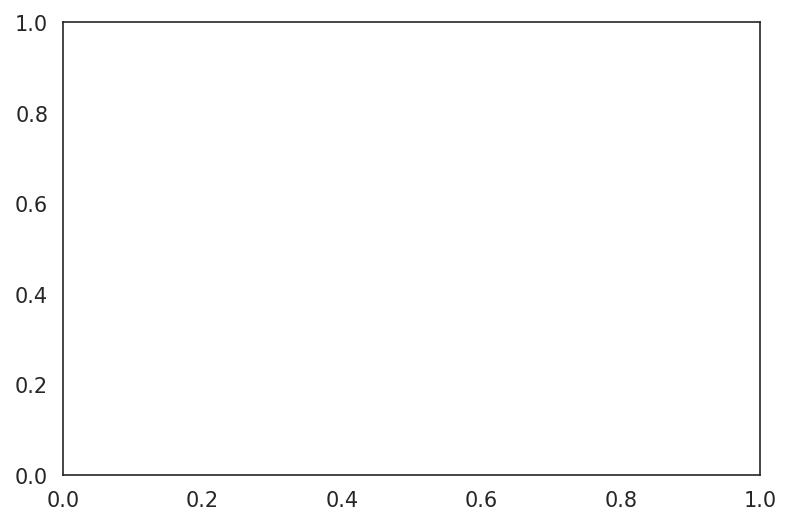

In [11]:
import seaborn as sns
sns.set_style("white")

plt.rcParams['figure.dpi'] = 150 #分辨率
fig, ax1 = plt.subplots()


tidy = df[['Position','ExactMatch','Within 1-st order nodes','Within 2-nd order nodes']]\
    .melt(id_vars='Position').rename(columns=str.title)
sns.barplot(x='Position', y='Value', hue='Variable', data=tidy, ax=ax1,palette="muted")

ax1.set(ylim=(0.4, 0.9))
ax1.set_ylabel('Match ratio',fontsize=15)    
ax1.set_xlabel('Position',fontsize=15)
ax1.legend().set_title('')
sns.despine(fig)

In [19]:
click_table = PDtable()
Exactmatch_ratio_ranks = session_calculation(getBinaryMatch,filter_click=True)
#add_to_df(system_table, Exactmatch_ratio_ranks, 'ExactMatchRatio')
avg_list = printRanks(Exactmatch_ratio_ranks)
click_table.add(avg_list,'ExactMatch')

100%|██████████| 89737/89737 [00:00<00:00, 100491.74it/s]


Position:  0
Total size:  123632
Match rate:  0.6609777403908373
Position:  1
Total size:  36636
Match rate:  0.6594333442515559
Two-sample t-statistic D =  0.548, p-value = 0.5835
Position:  2
Total size:  18670
Match rate:  0.6797000535618639
Two-sample t-statistic D = -5.047, p-value = 0.0000
Position:  3
Total size:  11536
Match rate:  0.6893203883495146
Two-sample t-statistic D = -6.162, p-value = 0.0000
Position:  4
Total size:  7716
Match rate:  0.6762571280456194
Two-sample t-statistic D = -2.753, p-value = 0.0059
Position:  5
Total size:  4544
Match rate:  0.6294014084507042
Two-sample t-statistic D =  4.413, p-value = 0.0000
Position:  6
Total size:  3482
Match rate:  0.641298104537622
Two-sample t-statistic D =  2.418, p-value = 0.0156
Position:  7
Total size:  2818
Match rate:  0.6689141234918382
Two-sample t-statistic D = -0.880, p-value = 0.3788
Position:  8
Total size:  2277
Match rate:  0.6855511638120334
Two-sample t-statistic D = -2.455, p-value = 0.0141
Position:  9


In [20]:
NeibhorBinaryMatchRatio_ranks = session_calculation(getNeibhorBinaryMatchRatio1,filter_click=True)
avg_list = printRanks(NeibhorBinaryMatchRatio_ranks)
print 'match_count: ', match_count
click_table.add(avg_list,'Neibhor1BinaryMatchRatio')

100%|██████████| 89737/89737 [00:01<00:00, 77642.61it/s]


Position:  0
Total size:  123632
Match rate:  0.6663566067037661
Position:  1
Total size:  36636
Match rate:  0.6615896931979474
Two-sample t-statistic D =  1.698, p-value = 0.0895
Position:  2
Total size:  18670
Match rate:  0.6829673272629887
Two-sample t-statistic D = -4.494, p-value = 0.0000
Position:  3
Total size:  11536
Match rate:  0.6916608876560333
Two-sample t-statistic D = -5.522, p-value = 0.0000
Position:  4
Total size:  7716
Match rate:  0.6797563504406429
Two-sample t-statistic D = -2.423, p-value = 0.0154
Position:  5
Total size:  4544
Match rate:  0.6362235915492958
Two-sample t-statistic D =  4.228, p-value = 0.0000
Position:  6
Total size:  3482
Match rate:  0.6450315910396324
Two-sample t-statistic D =  2.631, p-value = 0.0085
Position:  7
Total size:  2818
Match rate:  0.6710432931156849
Two-sample t-statistic D = -0.522, p-value = 0.6018
Position:  8
Total size:  2277
Match rate:  0.6877470355731226
Two-sample t-statistic D = -2.146, p-value = 0.0319
Position:  9

In [21]:
NeibhorBinaryMatchRatio_ranks = session_calculation(getNeibhorBinaryMatchRatio2,filter_click=True)
avg_list = printRanks(NeibhorBinaryMatchRatio_ranks)
print 'match_count: ', match_count
click_table.add(avg_list,'Neibhor2BinaryMatchRatio')

100%|██████████| 89737/89737 [00:01<00:00, 65462.75it/s]


Position:  0
Total size:  123632
Match rate:  0.720274686165394
Position:  1
Total size:  36636
Match rate:  0.73070204170761
Two-sample t-statistic D = -3.916, p-value = 0.0001
Position:  2
Total size:  18670
Match rate:  0.744617032672737
Two-sample t-statistic D = -6.932, p-value = 0.0000
Position:  3
Total size:  11536
Match rate:  0.7413314840499307
Two-sample t-statistic D = -4.829, p-value = 0.0000
Position:  4
Total size:  7716
Match rate:  0.7387247278382582
Two-sample t-statistic D = -3.507, p-value = 0.0005
Position:  5
Total size:  4544
Match rate:  0.7372359154929577
Two-sample t-statistic D = -2.503, p-value = 0.0123
Position:  6
Total size:  3482
Match rate:  0.7352096496266514
Two-sample t-statistic D = -1.937, p-value = 0.0527
Position:  7
Total size:  2818
Match rate:  0.7377572746628814
Two-sample t-statistic D = -2.045, p-value = 0.0408
Position:  8
Total size:  2277
Match rate:  0.7505489679402723
Two-sample t-statistic D = -3.191, p-value = 0.0014
Position:  9
Tot

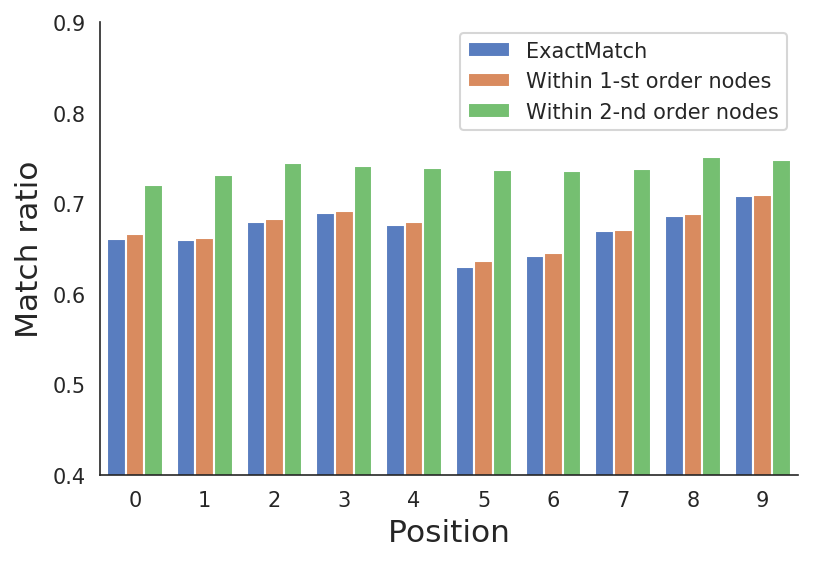

In [22]:
fig, ax1 = plt.subplots()
click_table.add(range(10),'Position')
df = click_table.to_pandas()
df.rename(columns={'BinaryMatch':'ExactMatch',
                   'Neibhor1BinaryMatchRatio':'Within 1-st order nodes',
                   'Neibhor2BinaryMatchRatio':'Within 2-nd order nodes'},
          inplace=True)

tidy = df[['Position','ExactMatch','Within 1-st order nodes','Within 2-nd order nodes']]\
    .melt(id_vars='Position').rename(columns=str.title)
sns.barplot(x='Position', y='Value', hue='Variable', data=tidy, ax=ax1,palette="muted")

ax1.set(ylim=(0.4, 0.9))
ax1.set_ylabel('Match ratio',fontsize=15)    
ax1.set_xlabel('Position',fontsize=15)
ax1.legend().set_title('')
sns.despine(fig)


In [5]:
#delta entity
delta_entity = []
delta_text = []
frist_query_entity_contains = []
last_query_entity_contains = []
first_query_text = []
last_query_text = []


max_growth_t = 0;t_sess = []
max_growth_e = 0;r_sess = []

def remove_space(text):
    return ''.join(text.split(' '))

def get_words(text):
    return text.split(' ')

def contain_percent(last_list,cur_list):
    count = 0
    for ent in cur_list:
        if ent in last_list:
            count += 1
    return float(count) / (len(cur_list) + 1)


for session in tqdm.tqdm(session_data[:]):
    qids = session['qids']
    docs = session['docs']

    for i in range(1,len(qids)):
        first_query_text.append(contain_percent(get_words(qdid2text_dict[qids[0]]),get_words(qdid2text_dict[qids[i]])))
        last_query_text.append(contain_percent(get_words(qdid2text_dict[qids[i-1]]),get_words(qdid2text_dict[qids[i]])))
        
        frist_query_entity_contains.append(contain_percent(qid2eid[qids[0]],qid2eid[qids[i]]))
        last_query_entity_contains.append(contain_percent(qid2eid[qids[i-1]],qid2eid[qids[i]]))
        growth_t = len(remove_space(qdid2text_dict[qids[i]]))\
                            - len(remove_space(qdid2text_dict[qids[i-1]]))
        growth_e = len(qid2eid[qids[i]]) - len(qid2eid[qids[i-1]])
        
        if growth_t > max_growth_t:
            max_growth_t = growth_t
            t_sess= qids
        
        if growth_e > max_growth_e:
            max_growth_e = growth_e
            e_sess= qids
            
        delta_text.append(growth_t)
        delta_entity.append(growth_e)

print 'max_text_delta: ',max_growth_t
print 'session, '
for qid in t_sess:
    print 'len: ',len(qdid2text_dict[qid].split())
    print qdid2text_dict[qid]

print 'max_ent_delta: ',max_growth_e
print 'session, '
for qid in e_sess:
    print qdid2text_dict[qid]
    
from scipy import stats
print 'Avg Entity: ', np.mean(delta_entity)
print stats.ttest_1samp(delta_entity,0)

#print delta_text
print 'Avg Text: ', np.mean(delta_text)
print stats.ttest_1samp(delta_text,0)

print 'Avg Frist query entity: ', np.mean(frist_query_entity_contains)
print 'Avg Frist query text: ', np.mean(first_query_text)
print stats.ttest_1samp(frist_query_entity_contains,0)

print 'Avg Last query entity: ', np.mean(last_query_entity_contains)
print 'Avg Last query text: ', np.mean(last_query_text)
print stats.ttest_1samp(last_query_entity_contains,0)

UnicodeEncodeError: 'ascii' codec can't encode characters in position 5-6: ordinal not in range(128)

In [5]:
common_text_in_session = []
common_entity_in_session = []

lowest_text_r = 0;low_sess = []
lowest_ent_r = 0;low_sess_ent = []
for session in tqdm.tqdm(session_data[:]):
    qids = session['qids']
    docs = session['docs']
    words_lists = map(lambda qid:get_words(qdid2text_dict[qid]),qids)
    entities_lists = map(lambda qid:qid2eid[qid],qids)
    
    common_words = set.intersection(*map(set, words_lists))
    common_entities = set.intersection(*map(set, entities_lists))
    
    for qid in qids[:1]:
        rate_text = float(len(common_words)) / (len(get_words(qdid2text_dict[qid]))+1)
        rate_entity = float(len(common_entities)) / (len(qid2eid[qid])+1)
        
        if rate_text > lowest_text_r:
            lowest_text_r = rate_text
            low_sess= qids
        
        if rate_entity > lowest_ent_r:
            lowest_ent_r = rate_entity
            low_sess_ent= qids
            
        common_text_in_session.append(rate_text)
        common_entity_in_session.append(rate_entity)

print 'Avg Common query entity: ', np.mean(common_entity_in_session)
print 'Avg Common query text: ', np.mean(common_text_in_session)

print 'lowest_text_r: ',lowest_text_r
print 'session, '
for qid in low_sess:
    print qdid2text_dict[qid]
print '--------'
print 'lowest_ent_r: ', lowest_ent_r
print 'session, '
for qid in low_sess_ent:
    print qdid2text_dict[qid]

100%|██████████| 89737/89737 [00:01<00:00, 76865.82it/s]

Avg Common query entity:  0.30367128386284364
Avg Common query text:  0.3571381804088713
lowest_text_r:  0.9
session, 
喜羊羊 与 灰 太 狼 之 妈妈 乐 疯狂
喜羊羊 与 灰 太 狼 之 妈妈 乐 疯狂 全集
--------
lowest_ent_r:  0.833333333333
session, 
4 月 “ 兰 的 秘密 基地
4 月 + 兰 的 秘密 基地 + 限免 商城


In [8]:
from collections import defaultdict
n1_neig_list_dict = defaultdict(list)
n2_neig_list_dict = defaultdict(list)

for (p1,p2) in tqdm.tqdm(neib_dict_1):
    n1_neig_list_dict[p1].append(p2)

for (p1,p2) in tqdm.tqdm(neib_dict_2):
    n2_neig_list_dict[p1].append(p2)

print 'n1_neig_list_dict: ',len(n1_neig_list_dict)
print 'n2_neig_list_dict: ',len(n2_neig_list_dict)

NameError: name 'neib_dict_1' is not defined

In [6]:
multi_step_precision = [[],[],[]] #0,1,2
multi_step_recall = [[],[],[]]

def cal_pr(ent1s,ent2s,step):
    ent1s = list(set(ent1s))
    ent2s = list(set(ent2s))
    if step == 0:
        common = float(len(set.intersection(*map(set, [ent1s,ent2s]))))
        prec = common / (len(ent2s) + 1)
        recall = common / (len(ent1s) + 1)
    else:
        p_count = 0;r_total = len(ent1s)
        for ent in ent1s:
            if ent in ent2s:
                p_count += 1
                continue
            for d_ent in ent2s:
                if step == 1:
                    if (ent,d_ent) in neib_dict_1 or (d_ent,ent) in neib_dict_1:
                        p_count += 1
                if step == 2:
                    if (ent,d_ent) in neib_dict_1 or (d_ent,ent) in neib_dict_1 or\
                            (ent,d_ent) in neib_dict_2 or (d_ent,ent) in neib_dict_2:
                        p_count += 1
                    
        for ent in ent1s:
            if step >= 1 and ent in n1_neig_list_dict:
                r_total += len(n1_neig_list_dict[ent])
            if step >= 2 and ent in n2_neig_list_dict:
                r_total += len(n2_neig_list_dict[ent])
        prec = float(p_count) / (len(ent2s) + 1)
        recall = float(p_count) / (r_total + 1)
    return (prec,recall)
        

In [16]:
def cal_session_spread(step):
    pres = [];recalls = []
    for session in tqdm.tqdm(session_data[:]):
        qids = session['qids']
        docs = session['docs'] 
        entities_lists = map(lambda qid:qid2eid[qid],qids)
        
        for i in range(1,len(qids)):
            ent1s = entities_lists[i-1]
            ent2s = entities_lists[i]
            (prec,recall) = cal_pr(ent1s,ent2s,step)
            pres.append(prec)
            recalls.append(recall)
    
    print 'Step: ', step
    print 'Precision: ', np.mean(pres)
    print 'Recall: ', np.mean(recalls)
    return (np.mean(pres),np.mean(recalls)),(pres,recalls)

(p0,r0),(pl0,rl0) = cal_session_spread(0)
        

100%|██████████| 89737/89737 [00:00<00:00, 94358.10it/s]

Step:  0
Precision:  0.31552031399172586
Recall:  0.3458851054300296


In [16]:
(p1,r1),(pl1,rl1) = cal_session_spread(1)
print 'Precision T-test: ', stats.ttest_ind(pl0,pl1)
print 'Recall T-test: ', stats.ttest_ind(rl0,rl1)

100%|██████████| 89737/89737 [00:00<00:00, 108149.43it/s]

Step:  1
Precision:  0.3158677793100197
Recall:  0.12682054108205215
Precision T-test:  Ttest_indResult(statistic=-0.3398128041467359, pvalue=0.7339977571592263)
Recall T-test:  Ttest_indResult(statistic=252.49709421387107, pvalue=0.0)


In [17]:
(p2,r2),(pl2,rl2) = cal_session_spread(2)
print 'Precision T-test: ', stats.ttest_ind(pl0,pl2)
print 'Recall T-test: ', stats.ttest_ind(rl0,rl2)

100%|██████████| 89737/89737 [00:01<00:00, 88857.14it/s]

Step:  2
Precision:  0.3329934113598057
Recall:  0.011490477242076889
Precision T-test:  Ttest_indResult(statistic=-16.92769994044636, pvalue=3.0245765940476027e-64)
Recall T-test:  Ttest_indResult(statistic=425.65744523657224, pvalue=0.0)


In [18]:
columns = ["labels", "values_a", "values_b", "values_x", "values_y"]
test_data = pd.DataFrame.from_records([("date1", 1, 3, 150, 170),\
                                       ("date2", 2, 6, 200, 180)],\
                                       columns=columns)
print test_data

  labels  values_a  values_b  values_x  values_y
0  date1         1         3       150       170
1  date2         2         6       200       180


   Hops  Precision    Recall
0     0   0.345885  0.315520
1     1   0.126821  0.315868
2     2   0.011490  0.332993


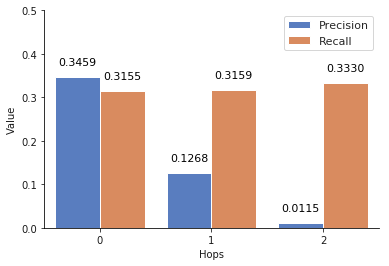

In [19]:
columns = ["labels", "values_a", "values_b", "values_x", "values_y"]
df = pd.DataFrame({"Hops": [0,1,2],
                   "Recall": [p0,p1,p2], 
                   "Precision": [r0,r1,r2]})
print df
import seaborn as sns
fig, ax = plt.subplots()
tidy = df.melt(id_vars='Hops').rename(columns=str.title)

sns.set(style="white")
ax.set(ylim=(0, 0.5))
g = sns.barplot(x='Hops', y='Value', hue='Variable', data=tidy, ax=ax,
	palette="muted")
sns.despine(fig)


#for index, row in df.iterrows():
#    print index,row
#    #g.text(row.name,row.Value, round(row.total_bill,2), color='black', ha="center")
for p in ax.patches:
	ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()-0.012),
		ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
		textcoords='offset points')
    
# Create a second y-axis with the scaled ticks
ax.legend().set_title('')
ax.set_ylabel('Value')
'''
ax2 = ax.twinx()

# Ensure ticks occur at the same positions, then modify labels
ax2.set_ylim(ax.get_ylim())
#ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))
ax2.set_ylabel('Recall')
'''
plt.show()

In [15]:
import itertools
def cal_context_spread(step):
    pres = [];recalls = []
    for session in tqdm.tqdm(session_data[:]):
        qids = session['qids']
        docs = session['docs'] 
        entities_lists = map(lambda qid:qid2eid[qid],qids)
        
        ent1s = list(itertools.chain(*entities_lists[:-1]))
        ent1s = list(set(ent1s))
        
        ent2s = entities_lists[-1]

        (prec,recall) = cal_pr(ent1s,ent2s,step)
        pres.append(prec)
        recalls.append(recall)
    
    print 'Step: ', step
    print 'Precision: ', np.mean(pres)
    print 'Recall: ', np.mean(recalls)
    return (np.mean(pres),np.mean(recalls)),(pres,recalls)

In [21]:
(pc0,rc0),(plc0,rlc0) = cal_context_spread(0)

100%|██████████| 89737/89737 [00:00<00:00, 113415.59it/s]


Step:  0
Precision:  0.3598656815657607
Recall:  0.3624701000903828


In [22]:
(pc1,rc1),(plc1,rlc1) = cal_context_spread(1)
print 'Precision T-test: ', stats.ttest_ind(plc0,plc1)
print 'Recall T-test: ', stats.ttest_ind(rlc0,rlc1)

100%|██████████| 89737/89737 [00:00<00:00, 94659.00it/s]

Step:  1
Precision:  0.36039630624305846
Recall:  0.12848285766049047
Precision T-test:  Ttest_indResult(statistic=-0.42660559132227277, pvalue=0.6696671362176705)
Recall T-test:  Ttest_indResult(statistic=230.23790529102055, pvalue=0.0)


In [23]:
(pc2,rc2),(plc2,rlc2) = cal_context_spread(2)
print 'Precision T-test: ', stats.ttest_ind(plc0,plc1)
print 'Recall T-test: ', stats.ttest_ind(rlc0,rlc1)

100%|██████████| 89737/89737 [00:01<00:00, 81925.48it/s]


Step:  2
Precision:  0.3859069651685852
Recall:  0.009741235179461039
Precision T-test:  Ttest_indResult(statistic=-0.42660559132227277, pvalue=0.6696671362176705)
Recall T-test:  Ttest_indResult(statistic=230.23790529102055, pvalue=0.0)


   Hops  Precision    Recall
0     0   0.362470  0.359866
1     1   0.128483  0.360396
2     2   0.009741  0.385907


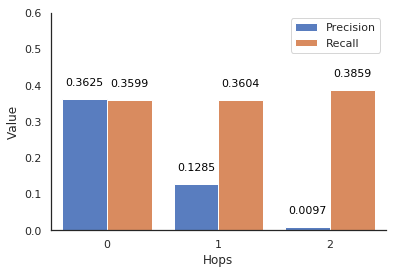

In [24]:
df = pd.DataFrame({"Hops": [0,1,2],
                   "Recall": [pc0,pc1,pc2], 
                   "Precision": [rc0,rc1,rc2]})
print df

fig, ax = plt.subplots()
tidy = df.melt(id_vars='Hops').rename(columns=str.title)

sns.set(style="white")
ax.set(ylim=(0, 0.6))
g = sns.barplot(x='Hops', y='Value', hue='Variable', data=tidy, ax=ax,
	palette="muted")
sns.despine(fig)


#for index, row in df.iterrows():
#    print index,row
#    #g.text(row.name,row.Value, round(row.total_bill,2), color='black', ha="center")
for p in ax.patches:
	ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()-0.01),
		ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
		textcoords='offset points')
    
# Create a second y-axis with the scaled ticks
ax.legend().set_title('')
ax.set_ylabel('Value')
'''
ax2 = ax.twinx()

# Ensure ticks occur at the same positions, then modify labels
ax2.set_ylim(ax.get_ylim())
#ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))
ax2.set_ylabel('Recall')
'''
plt.show()


In [16]:
import itertools
from collections import defaultdict

def cal_context_spread_ses_len(step,compare_prec = None):
    pres = defaultdict(list)
    recalls = defaultdict(list)
    
    for session in tqdm.tqdm(session_data[:]):
        qids = session['qids']
        docs = session['docs'] 
        entities_lists = map(lambda qid:qid2eid[qid],qids)
        
        ent1s = list(itertools.chain(*entities_lists[:1]))
        ent1s = list(set(ent1s))
        
        ent2s = entities_lists[-1]

        (prec,recall) = cal_pr(ent1s,ent2s,step)
        pres[len(qids)].append(prec)
        recalls[len(qids)].append(recall)
    
    print 'Step: ', step
    pre_list = [];rec_list = []
    
    for k,v in pres.iteritems():
        print 'len: ', k
        print 'Precision: ', np.mean(pres[k])
        print 'Recall: ', np.mean(recalls[k])
        if compare_prec != None:
            print 'Precision T-test: ', stats.ttest_ind(pres[k],compare_prec[k])
        pre_list.append(np.mean(pres[k]))
        rec_list.append(np.mean(recalls[k]))
    
    return (pres,recalls),(pre_list,rec_list)


In [26]:
(pcs0,rcs0),(pre_list0,rec_list0) = cal_context_spread_ses_len(0)

100%|██████████| 89737/89737 [00:00<00:00, 106349.91it/s]

Step:  0
len:  2
Precision:  0.3176551553759551
Recall:  0.36627021240301866
len:  3
Precision:  0.25852441224127914
Recall:  0.2893660766149989
len:  4
Precision:  0.23966452533904353
Recall:  0.26658815132048536
len:  5
Precision:  0.23827111464124967
Recall:  0.2621458829759068
len:  6
Precision:  0.2250262329485834
Recall:  0.2481112277019937
len:  7
Precision:  0.24579475308641976
Recall:  0.2640046296296296
len:  8
Precision:  0.2325795644891122
Recall:  0.26113902847571185
len:  9
Precision:  0.22098765432098766
Recall:  0.21496913580246915
len:  10
Precision:  0.20425531914893616
Recall:  0.22269503546099287


In [27]:
(pcs1,rcs1),(pre_list1,rec_list1) = cal_context_spread_ses_len(1,pcs0)

100%|██████████| 89737/89737 [00:00<00:00, 96343.15it/s] 

Step:  1
len:  2
Precision:  0.31815189962766244
Recall:  0.13874735745761274
Precision T-test:  Ttest_indResult(statistic=0.3380904766397232, pvalue=0.7352956331951281)
len:  3
Precision:  0.2589088630040661
Recall:  0.10801182179978397
Precision T-test:  Ttest_indResult(statistic=0.148191785900232, pvalue=0.8821920992913657)
len:  4
Precision:  0.240154651439448
Recall:  0.0983927713725106
Precision T-test:  Ttest_indResult(statistic=0.10827406007269812, pvalue=0.9137798494373285)
len:  5
Precision:  0.2386153031506487
Recall:  0.09730072504091826
Precision T-test:  Ttest_indResult(statistic=0.045753786653703984, pvalue=0.9635083079472425)
len:  6
Precision:  0.22555089192025182
Recall:  0.08942739343308564
Precision T-test:  Ttest_indResult(statistic=0.044082414418033206, pvalue=0.964843332856407)
len:  7
Precision:  0.2471450617283951
Recall:  0.08876180809914315
Precision T-test:  Ttest_indResult(statistic=0.07435142062006234, pvalue=0.9407480126209201)
len:  8
Precision:  0.23257

In [28]:
(pcs2,rcs2),(pre_list2,rec_list2) = cal_context_spread_ses_len(2,pcs0)

100%|██████████| 89737/89737 [00:01<00:00, 86414.86it/s]

Step:  2
len:  2
Precision:  0.3380687265818466
Recall:  0.011928699661077569
Precision T-test:  Ttest_indResult(statistic=13.708439729828285, pvalue=9.777477704729179e-43)
len:  3
Precision:  0.2779326790791525
Recall:  0.01199759979690419
Precision T-test:  Ttest_indResult(statistic=7.405877737559083, pvalue=1.3263282157363037e-13)
len:  4
Precision:  0.25876992624315964
Recall:  0.01073321346983421
Precision T-test:  Ttest_indResult(statistic=4.165904484974399, pvalue=3.119799321083832e-05)
len:  5
Precision:  0.25657267672756157
Recall:  0.011317178436875228
Precision T-test:  Ttest_indResult(statistic=2.405833666896229, pvalue=0.01617144279793101)
len:  6
Precision:  0.24394893319342426
Recall:  0.0087317520196134
Precision T-test:  Ttest_indResult(statistic=1.568227713850604, pvalue=0.11699416438419859)
len:  7
Precision:  0.26539351851851856
Recall:  0.014292435164427542
Precision T-test:  Ttest_indResult(statistic=1.06526251919618, pvalue=0.2870554379079461)
len:  8
Precision: 

      0-hop     1-hop     2-hop  Session
0  0.317655  0.318152  0.338069        2
1  0.258524  0.258909  0.277933        3
2  0.239665  0.240155  0.258770        4
3  0.238271  0.238615  0.256573        5
4  0.225026  0.225551  0.243949        6
5  0.245795  0.247145  0.265394        7
6  0.232580  0.232580  0.254188        8
7  0.220988  0.220988  0.232562        9
8  0.204255  0.204255  0.204255       10


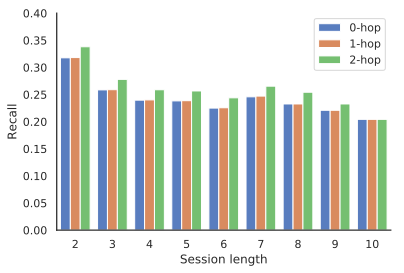

In [29]:
%config InlineBackend.figure_format='svg'
df = pd.DataFrame({"Session": range(2,11),
                   "0-hop": pre_list0, 
                   "1-hop": pre_list1,
                  "2-hop": pre_list2})
print df
import seaborn as sns

fig, ax = plt.subplots()
tidy = df.melt(id_vars='Session').rename(columns=str.title)

sns.set(style="white")
ax.set(ylim=(0, 0.4))
g = sns.barplot(x='Session', y='Value', hue='Variable', data=tidy, ax=ax,
	palette="muted")
sns.despine(fig)


#for index, row in df.iterrows():
#    print index,row
#    #g.text(row.name,row.Value, round(row.total_bill,2), color='black', ha="center")
'''
for p in ax.patches:
	ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()-0.01),
		ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
		textcoords='offset points')
'''
# Create a second y-axis with the scaled ticks
ax.legend().set_title('')
ax.set_xlabel('Session length')
ax.set_ylabel('Recall')
plt.show()

In [29]:
#Precision From the current query
#using the function cal_pr
def click_calculation(step):
    click_ratio = [[],[]];unclick_ratio = [[],[]]
    for session in tqdm.tqdm(session_data[:]):
        qids = session['qids']
        docs = session['docs']
        for qid,dids in zip(qids,docs):
            qid_entlist = qid2eid[qid]
            q_size = len(qid_entlist)
            for pos,(did,click) in enumerate(dids):
                did_entlist = did2eid[did]
                (p,r) = cal_pr(qid_entlist,did_entlist,step)
                if click == 0:
                    unclick_ratio[0].append(p)
                    unclick_ratio[1].append(r)
                else:
                    click_ratio[0].append(p)
                    click_ratio[1].append(r)
    
    print 'Step: ', step
    print 'Click precision: ', np.mean(click_ratio[0])
    print 'Click recall: ', np.mean(click_ratio[1])
    print '--------------------------'
    print 'UnClick precision: ', np.mean(unclick_ratio[0])
    print 'UnClick recall: ', np.mean(unclick_ratio[1])  
    return click_ratio,unclick_ratio

In [23]:
c,unc = click_calculation(0)

100%|██████████| 89737/89737 [00:11<00:00, 8077.20it/s]


Step:  0
Click precision:  0.23074349780140077
Click recall:  0.31544267271966814
--------------------------
UnClick precision:  0.18886011540252026
UnClick recall:  0.27425952879968196


In [89]:
c1,unc1 = click_calculation(1)


100%|██████████| 89737/89737 [00:14<00:00, 6032.22it/s]


Step:  1
Click precision:  0.23185423294969457
Click recall:  0.11445429558506043
--------------------------
UnClick precision:  0.19066753378394122
UnClick recall:  0.10012888712789052


In [90]:
c2,unc2 = click_calculation(2)

100%|██████████| 89737/89737 [00:20<00:00, 4411.38it/s]


Step:  2
Click precision:  0.2688178005861887
Click recall:  0.009424625624199774
--------------------------
UnClick precision:  0.23784797909061914
UnClick recall:  0.009769023871826803


In [103]:
print '--------c0 vs c1-------------'
print 'Click Precision T-test: ', stats.ttest_ind(c[0],c1[0])
print 'UnClick Precision T-test: ', stats.ttest_ind(unc[0],unc1[0])

print '--------c1 vs c2-------------'
print 'Click Precision T-test: ', stats.ttest_ind(c1[0],c2[0])
print 'UnClick Precision T-test: ', stats.ttest_ind(unc1[0],unc2[0])

--------c0 vs c1-------------
Click Precision T-test:  Ttest_indResult(statistic=-1.6773954680251932, pvalue=0.09346590935921194)
UnClick Precision T-test:  Ttest_indResult(statistic=-8.720925610652538, pvalue=2.7603896389208056e-18)
--------c1 vs c2-------------
Click Precision T-test:  Ttest_indResult(statistic=-54.104999225195236, pvalue=0.0)
UnClick Precision T-test:  Ttest_indResult(statistic=-220.67355463003892, pvalue=0.0)


In [91]:
click_precision = map(lambda t:np.mean(t[0]), [c,c1,c2])
unclick_precision = map(lambda t:np.mean(t[0]), [unc,unc1,unc2])

      Click  Hops   Unclick
0  0.230743     0  0.188860
1  0.231854     1  0.190668
2  0.268818     2  0.237848


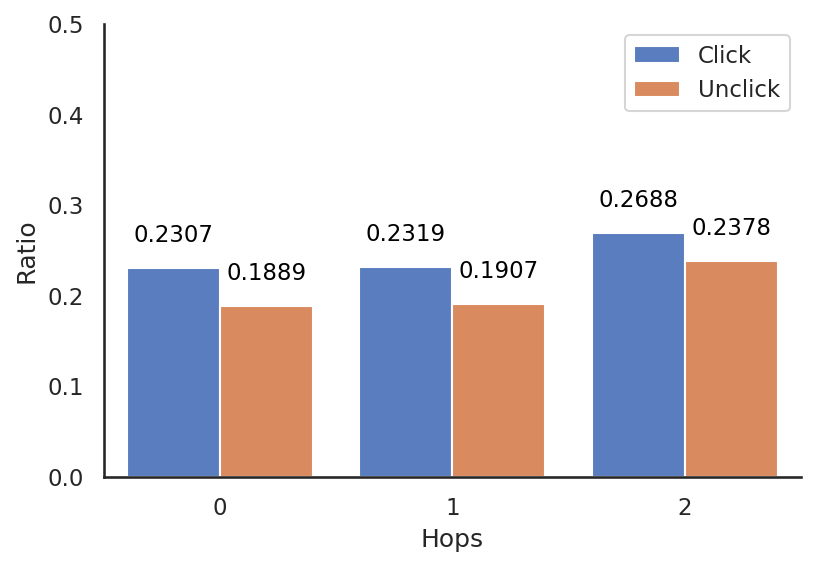

In [95]:
df = pd.DataFrame({"Hops": [0,1,2],
                   "Click": click_precision, 
                   "Unclick": unclick_precision})
print df

fig, ax = plt.subplots()
tidy = df.melt(id_vars='Hops').rename(columns=str.title)

sns.set(style="white")
ax.set(ylim=(0, 0.5))
g = sns.barplot(x='Hops', y='Value', hue='Variable', data=tidy, ax=ax,
	palette="muted")
sns.despine(fig)


#for index, row in df.iterrows():
#    print index,row
#    #g.text(row.name,row.Value, round(row.total_bill,2), color='black', ha="center")
for p in ax.patches:
	ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()-0.01),
		ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
		textcoords='offset points')
    
# Create a second y-axis with the scaled ticks
ax.legend().set_title('')
ax.set_ylabel('Ratio')
plt.show()

In [55]:
def click_context_calculation(step,use_click=False):
    click_ratio = [[],[]];unclick_ratio = [[],[]]
    for session in tqdm.tqdm(session_data[:]):
        qids = session['qids']
        docs = session['docs']
        
        entities_lists = map(lambda qid:qid2eid[qid],qids)
        
        if use_click:
            for dids in docs[:-1]:
                for pos,(did,click) in enumerate(dids):
                    if click != 0:
                        did_entlist = did2eid[did]
                        entities_lists.append(did_entlist)
        
        ent1s = list(itertools.chain(*entities_lists))
        ent1s = list(set(ent1s))
        
        dids = docs[-1]
        for pos,(did,click) in enumerate(dids):
            did_entlist = did2eid[did]
            (p,r) = cal_pr(ent1s,did_entlist,step)
            if click == 0:
                unclick_ratio[0].append(p)
                unclick_ratio[1].append(r)
            else:
                click_ratio[0].append(p)
                click_ratio[1].append(r)
    
    print 'Step: ', step
    print 'Click precision: ', np.mean(click_ratio[0])
    print 'Click recall: ', np.mean(click_ratio[1])
    print '--------------------------'
    print 'UnClick precision: ', np.mean(unclick_ratio[0])
    print 'UnClick recall: ', np.mean(unclick_ratio[1])  
    return click_ratio,unclick_ratio

In [56]:
c_cxtq,unc_cxtq = click_context_calculation(0)
c_cxtq1,unc_cxtq1 = click_context_calculation(1)
c_cxtq2,unc_cxtq2 = click_context_calculation(2)

  0%|          | 0/89737 [00:00<?, ?it/s]

Step:  0
Click precision:  0.26285389990074587
Click recall:  0.2781512353240508
--------------------------
UnClick precision:  0.22426101187007547
UnClick recall:  0.24873174552225244


  0%|          | 0/89737 [00:00<?, ?it/s]

Step:  1
Click precision:  0.2642798180013562
Click recall:  0.08736240501080564
--------------------------
UnClick precision:  0.22659538352598813
UnClick recall:  0.07731037071753465


100%|██████████| 89737/89737 [00:15<00:00, 5723.58it/s]


Step:  2
Click precision:  0.33417191599760226
Click recall:  0.004026843236155516
--------------------------
UnClick precision:  0.31074955235582674
UnClick recall:  0.003764030112744063


In [57]:
print '--------c0 vs c1-------------'
print 'Click Precision T-test: ', stats.ttest_ind(c_cxtq[0],c_cxtq1[0])
print 'UnClick Precision T-test: ', stats.ttest_ind(unc_cxtq[0],unc_cxtq1[0])

print '--------c1 vs c2-------------'
print 'Click Precision T-test: ', stats.ttest_ind(c_cxtq1[0],c_cxtq2[0])
print 'UnClick Precision T-test: ', stats.ttest_ind(unc_cxtq1[0],unc_cxtq2[0])

--------c0 vs c1-------------
Click Precision T-test:  Ttest_indResult(statistic=-1.423975578847097, pvalue=0.15445507471117728)
UnClick Precision T-test:  Ttest_indResult(statistic=-6.595408451038376, pvalue=4.24225580168053e-11)
--------c1 vs c2-------------
Click Precision T-test:  Ttest_indResult(statistic=-63.9911772894142, pvalue=0.0)
UnClick Precision T-test:  Ttest_indResult(statistic=-214.96710717861285, pvalue=0.0)


In [58]:
click_precision = map(lambda t:np.mean(t[0]), [c_cxtq,c_cxtq1,c_cxtq2])
unclick_precision = map(lambda t:np.mean(t[0]), [unc_cxtq,unc_cxtq1,unc_cxtq2])

      Click  Hops   Unclick
0  0.262854     0  0.224261
1  0.264280     1  0.226595
2  0.334172     2  0.310750


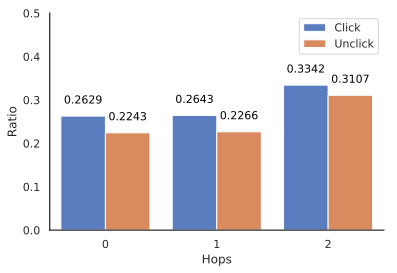

In [61]:
df = pd.DataFrame({"Hops": [0,1,2],
                   "Click": click_precision, 
                   "Unclick": unclick_precision})
print df

fig, ax = plt.subplots()
tidy = df.melt(id_vars='Hops').rename(columns=str.title)

#print tidy
sns.set(style="white")
ax.set(ylim=(0, 0.5))
g = sns.barplot(x='Hops', y='Value', hue='Variable', data=tidy, ax=ax,
	palette="muted")
sns.despine(fig)


#for index, row in df.iterrows():
#    print index,row
#    #g.text(row.name,row.Value, round(row.total_bill,2), color='black', ha="center")
for p in ax.patches:
	ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()-0.01),
		ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
		textcoords='offset points')
    
# Create a second y-axis with the scaled ticks
ax.legend().set_title('')
ax.set_ylabel('Ratio')
plt.show()



In [53]:
c_cxtqc,unc_cxtqc = click_context_calculation(0,use_click=True)
c_cxtqc1,unc_cxtqc1 = click_context_calculation(1,use_click=True)
c_cxtqc2,unc_cxtqc2 = click_context_calculation(2,use_click=True)

NameError: name 'click_context_calculation' is not defined

In [ ]:
print '--------c0 vs c1-------------'
print 'Click Precision T-test: ', stats.ttest_ind(c_cxtqc[0],c_cxtqc1[0])
print 'UnClick Precision T-test: ', stats.ttest_ind(unc_cxtqc[0],unc_cxtqc1[0])

print '--------c1 vs c2-------------'
print 'Click Precision T-test: ', stats.ttest_ind(c_cxtqc1[0],c_cxtqc2[0])
print 'UnClick Precision T-test: ', stats.ttest_ind(unc_cxtqc1[0],unc_cxtqc2[0])

In [52]:
click_precision = map(lambda t:np.mean(t[0]), [c_cxtqc,c_cxtqc1,c_cxtqc2])
unclick_precision = map(lambda t:np.mean(t[0]), [unc_cxtqc,unc_cxtqc1,unc_cxtqc2])

NameError: name 'c_cxtqc' is not defined

In [51]:
df = pd.DataFrame({"Hops": [0,1,2],
                   "Click": click_precision, 
                   "Unclick": unclick_precision})
print df

fig, ax = plt.subplots()
tidy = df.melt(id_vars='Hops').rename(columns=str.title)

sns.set(style="white")
ax.set(ylim=(0, 0.6))
g = sns.barplot(x='Hops', y='Value', hue='Variable', data=tidy, ax=ax,
	palette="muted")
sns.despine(fig)


#for index, row in df.iterrows():
#    print index,row
#    #g.text(row.name,row.Value, round(row.total_bill,2), color='black', ha="center")
for p in ax.patches:
	ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()-0.01),
		ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
		textcoords='offset points')
    
# Create a second y-axis with the scaled ticks
ax.legend().set_title('')
ax.set_ylabel('Ratio')
plt.show()


NameError: name 'click_precision' is not defined

In [7]:
#understanding the entity in different reformulation type
import re
def keepwordsonly(words):
    #print 'words: ', words
    line = ''.join(words)
    line = line.decode("utf8")
    string = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？?、~@#￥%……&*（）]+".decode("utf8"), "".decode("utf8"),line)
    return string

def reformulationClassfier(query1,query2):
    words1 = map(str,query1)
    words2 = map(str,query2)
    
    common_words = set.intersection(*map(set, [words1,words2]))
    
    raw_words1 = keepwordsonly(words1)
    raw_words2 = keepwordsonly(words2)
    if raw_words1 == raw_words2:
        return 'R'#Repeat
    
    if len(common_words) > 0:
        if len(words1) > len(words2):
            return 'G' #Generalization
        elif len(words1) < len(words2):
            return 'S' #Specialization
        else:
            for w in words2:
                if w not in words1:
                    return 'WR' #word substitution
        
    return 'N'#new

reformulationClassfier(['虎牙','直播'], ['虎牙',',','直播'])

'R'

In [2]:
def loadNeigborRelation(step):
    print 'run'
    addr = '/ivi/ilps/personal/xli/knowledge_intent/data/neib_%d_relation.txt' % step
    neib_dict = {};
    for line in tqdm.tqdm(open(addr)):
        elements = line.strip().split('\t')
        relations = map(int,elements[-1].split('#'))
        neib_dict[(elements[0],elements[1])] = (int(elements[2]),relations)
        #break
    return neib_dict

relation_dict1 = loadNeigborRelation(1)
relation_dict2 = loadNeigborRelation(2)
#print relation_dict

31352it [00:00, 313519.55it/s]

run


135814it [00:00, 138481.84it/s]
36497it [00:00, 364969.48it/s]

run


42119584it [03:01, 232471.06it/s]


In [19]:
rel_count = defaultdict(lambda:0)
for k,v in relation_dict1.iteritems():
    for r in v[1]:
        rel_count[r] += 1
print rel_count

defaultdict(<function <lambda> at 0x7f4f161f5f50>, {1: 113614, 2: 1644, 3: 20298, 4: 258})


In [20]:
rel_count = defaultdict(lambda:0)
for k,v in relation_dict2.iteritems():
    for r in v[1]:
        rel_count[r] += 1
print rel_count

defaultdict(<function <lambda> at 0x7f4f161f56e0>, {1: 83213162, 2: 210337, 3: 800562, 4: 15104})


In [11]:
def gethops(ent1s,ent2s):
    hops = []
    derivation = 0
    equal = 0
    has_same = 0
    for e1 in ent1s:
        for e2 in ent2s:
            if e1 == e2:
                #continue
                has_same = 1
                hops.append(0)
            else:
                if (e1,e2) in relation_dict1 or (e2,e1) in relation_dict1:
                    ent1 = e1;ent2 = e2
                    if (e1,e2) not in relation_dict1:
                        ent2 = e1;ent1 = e2s
                        
                    hops.append(1)
                    for r in relation_dict1[(ent1,ent2)][1]:
                        #print 'runhere'
                        if r == 1 or r == 2:
                            derivation += 1
                        else:
                            equal += 1
                elif (e1,e2) in relation_dict2 or (e2,e1) in relation_dict2:
                    ent1 = e1;ent2 = e2
                    if (e1,e2) not in relation_dict2:
                        ent2 = e1;ent1 = e2s
                        
                    hops.append(2)
                    for r in relation_dict2[(ent1,ent2)][1]:
                        if r == 1 or r == 2:
                            derivation += 1
                        else:
                            equal += 1
                #else:
                    #hops.append(0)
    total_r = derivation + equal
    if len(hops) == 0:
        avg_hops = 0
    else:
        avg_hops = np.mean(hops)
    if total_r == 0:
        return avg_hops,0,0,has_same
    return avg_hops,float(derivation)/total_r, float(equal)/total_r,has_same
                    

In [4]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')

#query Reformulation spread in terms of relation types
from collections import defaultdict

type_count = defaultdict(lambda:0)
delta_e_count = defaultdict(list)
ehops_count = defaultdict(list)
rel_count = defaultdict(list)

for session in tqdm.tqdm(session_data):
    qids = session['qids']
    docs = session['docs']
    
    words_lists = map(lambda qid:get_words(qdid2text_dict[qid]),qids)
    entities_lists = map(lambda qid:qid2eid[qid],qids)
    
    #entities_lists = map(lambda qid:qid2eid[qid],qids)
    
    for i in range(1,len(qids)):
        #print words_lists[i-1]
        reformulate_type = reformulationClassfier(words_lists[i-1],words_lists[i])
        type_count[reformulate_type] += 1
        
        delta_e = 0
        for e in entities_lists[i]:
            if e not in entities_lists[i-1]:
                delta_e += 1
        delta_e = float(delta_e) / (len(entities_lists[i])+ 1)
        #delta_e = len(entities_lists[i]) - len(entities_lists[i-1])
        delta_e_count[reformulate_type].append(delta_e)
        
        hops, dev, eq = gethops(entities_lists[i-1],entities_lists[i])
        if hops > 0:
            ehops_count[reformulate_type].append(hops)
            rel_count[str(reformulate_type) + 'dev'].append(dev)
            rel_count[str(reformulate_type) + 'eq'].append(eq)
print type_count

for qtype in delta_e_count:
    print 'qtype:', qtype
    print 'Delta E:', np.mean(delta_e_count[qtype])
    print stats.ttest_1samp(delta_e_count[qtype],0)
    
    print '--------------'
    print 'Avg hops: ',np.mean(ehops_count[qtype])
    dev = np.mean(rel_count[str(qtype)+'dev'])
    eq = np.mean(rel_count[str(qtype)+'eq'])
    total_r = dev + eq
    if total_r == 0:
        print 'dev:0,eq:0'
    else:
        print 'dev: ', float(dev)# / total_r
        print 'eq: ', float(eq)# / total_r



NameError: global name 'get_words' is not defined

In [8]:
import cPickle
prefix_data_addr = '/ivi/ilps/personal/xli/knowledge_intent/entity/'
(ent2id, id2ent) = cPickle.load(open(prefix_data_addr + 'raw-xlore.ent_dict.pkl'))

In [14]:
#document clicking spread in terms of relation types
from collections import defaultdict
import scipy.stats as stats
click_count = defaultdict(list)
unclick_count = defaultdict(list)
click_hops = [];unclick_hops = []
click_num = 0;unclick_num = 0

click_percent = defaultdict(list)
click_e_rate = defaultdict(list)

print_times = 0;cur_print = 0
comments = ''
for session in tqdm.tqdm(session_data):
    qids = session['qids']
    docs = session['docs']
    
    #words_lists = map(lambda qid:get_words(qdid2text_dict[qid]),qids)
    #entities_lists = map(lambda qid:qid2eid[qid],qids)
    
    #entities_lists = map(lambda qid:qid2eid[qid],qids)

    for i,qid in enumerate(qids):
        query_ents = qid2eid[qid]
        if len(query_ents) == 0:
            continue
        click_ents = []
        
        #if cur_print == print_times:
        #    break
        for pos,(did,click) in enumerate(docs[i]):
            did_entlist = did2eid[did]
            if len(did_entlist) == 0:
                continue
            hops, dev, eq, has_same = gethops(query_ents,did_entlist)
            common_es = set.intersection(*map(set, [query_ents,did_entlist]))
            
            if click != 0:
                click_hops.append(hops)
                if hops>0:
                    click_count['dev'].append(dev)
                    click_count['eq'].append(eq)
                click_num += 1
                click_percent['click'].append(has_same)
                click_e_rate['click'].append(float(len(common_es)) / (len(query_ents) + 1))
                
                distances = []
                rela_list = []
                '''
                for e1 in qid2eid[qid]:
                    for e2 in did2eid[did]:
                        if e1 == e2:
                            distances.append(0)
                        elif (e1,e2) in relation_dict1 or (e2,e1) in relation_dict1:
                            distances.append(1)
                            comments =  'E1: %s E2: %s' % (id2ent[e1],id2ent[e2])
                            rela = relation_dict1[(e1,e2)]
                            rela_list += rela[1]
                        elif (e1,e2) in relation_dict2 or (e2,e1) in relation_dict2:
                            distances.append(2)
                            comments =  'E1: %s E2: %s' % (id2ent[e1],id2ent[e2])
                            rela = relation_dict2[(e1,e2)]
                            rela_list += rela[1]
                        else:
                            distances.append(-1)
                '''              
                if cur_print < print_times and has_same == 0 and (2 in distances) and (3 in rela_list or 4 in rela_list):#(2 in distances):
                    print 'Query: ', qdid2text_dict[qid]
                    for i,e in enumerate(map(lambda e:id2ent[e],qid2eid[qid])):
                        print ('E %d: %s' % (i,e))
                    print 'Doc: ', qdid2text_dict[did]
                    for i,e in enumerate(map(lambda e:id2ent[e],did2eid[did])):
                        print ('E %d: %s' % (i,e))
                    
                    print comments
                    print rela
                    
                    print distances
                    cur_print += 1
            else:
                unclick_hops.append(hops)
                if hops>0:   
                    unclick_count['dev'].append(dev)
                    unclick_count['eq'].append(eq)
                unclick_num += 1
                click_percent['unclick'].append(has_same)
                click_e_rate['unclick'].append(float(len(common_es)) / (len(query_ents) + 1))
                
print '-------Click---------'
print 'Percentage: ', (float(click_num)/(click_num + unclick_num))
print 'Avg hops: ', np.mean(click_hops)
print 'Has at least one entity Percent: ', np.mean(click_percent['click'])
print 'Query ent coverage: ', np.mean(click_e_rate['click'])
#print click_count
dev = np.mean(click_count['dev'])
eq = np.mean(click_count['eq'])
total_r = dev + eq
if total_r == 0:
    print 'dev:0,eq:0'
else:
    print 'dev: ', float(dev) #/ total_r
    print 'eq: ', float(eq) #/ total_r

print '-------UnClick---------'
print 'Percentage: ', (float(unclick_num)/(click_num + unclick_num))
print 'Avg hops: ', np.mean(unclick_hops)
print 'Avg hop T-test: ', stats.ttest_ind(click_hops,unclick_hops)

print 'Has at least one entity Percent: ', np.mean(click_percent['unclick'])
print 'Query ent coverage: ', np.mean(click_e_rate['unclick'])
dev = np.mean(unclick_count['dev'])
eq = np.mean(unclick_count['eq'])
total_r = dev + eq
if total_r == 0:
    print 'dev:0,eq:0'
else:
    print 'Dev: ', float(dev) #/ total_r
    print 'Dev T-test: ', stats.ttest_ind(click_count['dev'],unclick_count['dev'])
    print 'Eq: ', float(eq) #/ total_r 
    print 'Eq T-test: ', stats.ttest_ind(click_count['eq'],unclick_count['eq'])



In [9]:
from collections import defaultdict

ent_count = defaultdict(lambda:defaultdict(list))
    
for session in tqdm.tqdm(session_data[:]):
    qids = session['qids']
    docs = session['docs']
    
    words_lists = map(lambda qid:get_words(qdid2text_dict[qid]),qids)
    entities_lists = map(lambda qid:qid2eid[qid],qids)

    for i in range(len(qids)):
        ent_count[len(qids)][i].append(len(entities_lists[i]))

result = {}
for length in ent_count:
    result[length] = []
    for num in ent_count[length]:
        result[length].append(np.mean(ent_count[length][num]))


entity_in_session = result    
print entity_in_session

100%|██████████| 89737/89737 [00:00<00:00, 112055.14it/s]

{2: [2.1973742257671742, 2.614057068238367], 3: [1.9425387508025314, 2.209070897918004, 2.4451985692011373], 4: [1.8733761598857959, 2.1450392576730906, 2.162883654532477, 2.332762312633833], 5: [1.8447180301826847, 2.1409849086576647, 2.1660047656870534, 2.1513105639396346, 2.283161239078634], 6: [1.7429171038824764, 2.074501573976915, 2.1017838405036726, 2.1406086044071353, 2.1322140608604405, 2.1878279118572928], 7: [1.7569444444444444, 1.9652777777777777, 2.0833333333333335, 2.0972222222222223, 2.0625, 2.1180555555555554, 2.1319444444444446], 8: [1.7035175879396984, 2.0603015075376883, 1.9748743718592965, 1.9748743718592965, 1.8542713567839195, 1.9095477386934674, 1.964824120603015, 2.170854271356784], 9: [1.7777777777777777, 2.009259259259259, 2.1203703703703702, 1.9814814814814814, 2.314814814814815, 2.1296296296296298, 2.2222222222222223, 1.9259259259259258, 1.7222222222222223], 10: [1.5957446808510638, 1.9148936170212767, 1.9148936170212767, 2.0425531914893615, 2.17021276595744

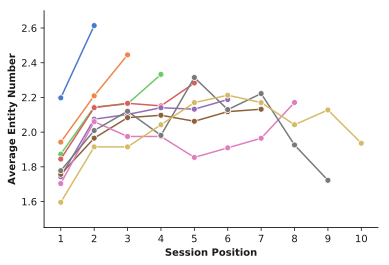

In [24]:
%config InlineBackend.figure_format='svg'
%matplotlib inline
import seaborn as sns

data = entity_in_session
data['Session'] = list(range(1,11))
df = pd.DataFrame(dict([ (str(k),pd.Series(v)) for k,v in data.iteritems() ]))

#print df

fig, ax = plt.subplots()
tidy = df.melt(id_vars='Session').rename(columns=str.title)


tidy = tidy.dropna()
#tidy.dropna()
#print tidy

sns.set(style="white")
ax.set(ylim=(1.45, 2.7))
ax.set(xlim=(0.5, 10.5))
g = sns.lineplot(x='Session', y='Value', hue='Variable', data=tidy, ax=ax,hue_order=map(str,range(2,11)),
	palette="muted",marker = 'o',legend=False)

sns.despine(fig)

font1 = {
'size'   : 10,
}
#'weight' : 'bold',


# Create a second y-axis with the scaled ticks
#ax.legend(prop=font1).set_title('')
plt.xticks(range(1, 11))
ax.set_xlabel('Session Position',weight='bold')
ax.set_ylabel('Average Entity Number',weight='bold')
plt.show()

In [31]:
ent_count = defaultdict(lambda:defaultdict(list))
import itertools

def getNew(ent1s,ent2s):
    num = 0
    for e in ent2s:
        if e not in ent1s:
            num += 1
    return num
for session in tqdm.tqdm(session_data[:]):
    qids = session['qids']
    docs = session['docs']
    
    words_lists = map(lambda qid:get_words(qdid2text_dict[qid]),qids)
    entities_lists = map(lambda qid:qid2eid[qid],qids)

    for i in range(0,len(qids)):
        if i == 0:
            ent_count[len(qids)][i].append(0)
        else:
            comp = list(itertools.chain(*entities_lists[:i]))
            ent_count[len(qids)][i].append(getNew(comp,entities_lists[i]))

result = {}
for length in ent_count:
    result[length] = []
    for num in ent_count[length]:
        result[length].append(np.mean(ent_count[length][num]))


newentity_in_session = result    
print newentity_in_session

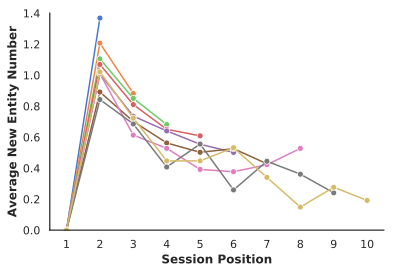

In [32]:
%config InlineBackend.figure_format='svg'
%matplotlib inline

data = newentity_in_session
data['Session'] = list(range(1,11))
df = pd.DataFrame(dict([ (str(k),pd.Series(v)) for k,v in data.iteritems() ]))

#print df

fig, ax = plt.subplots()
tidy = df.melt(id_vars='Session').rename(columns=str.title)


tidy = tidy.dropna()
#tidy.dropna()
#print tidy

sns.set(style="white")
ax.set(ylim=(0, 1.4))
ax.set(xlim=(0.5, 10.5))
g = sns.lineplot(x='Session', y='Value', hue='Variable', data=tidy, ax=ax,hue_order=map(str,range(2,11)),
	palette="muted",marker = 'o',legend=False)

sns.despine(fig)

font1 = {
'size'   : 10,
}
#'weight' : 'bold',


# Create a second y-axis with the scaled ticks
#ax.legend(prop=font1).set_title('')
plt.xticks(range(1, 11))
ax.set_xlabel('Session Position',weight='bold')
ax.set_ylabel('Average New Entity Number',weight='bold')
plt.show()

In [10]:
#calculate the click ratio
click_count = 0;total = 0
for session in tqdm.tqdm(session_data[:]):
    qids = session['qids']
    docs = session['docs']

    #entities_lists = map(lambda qid:qid2eid[qid],qids)

    for s_i,dids in enumerate(docs):
        is_click = 0
        for pos,(did,click) in enumerate(dids):
            if click != 0:
                is_click = 1
                break
        click_count += is_click
        total += 1

print 'Click ratio: ', (float(click_count)/total)

100%|██████████| 89737/89737 [00:00<00:00, 222864.36it/s]

Click ratio:  0.712501406062


In [13]:
def get_comp(comp_e,cur_e):
    num = 0
    for e in cur_e:
        if e in comp_e:
            num += 1
    #return 1 if num > 0 else 0
    #if len(comp_e) == 0 or len(cur_e) == 0:
    #    return -1
    return float(num) / (len(cur_e)+1)

qc_rates = [];qq_rates = []
qq_result_list = defaultdict(lambda:defaultdict(list))
qc_result_list = defaultdict(lambda:defaultdict(list))

result_dict = defaultdict(lambda:defaultdict())
result_list = defaultdict(lambda:defaultdict(list))

session_len_dict = defaultdict(lambda:0)

for session in tqdm.tqdm(session_data[:]):
    qids = session['qids']
    docs = session['docs']

    entities_lists = map(lambda qid:qid2eid[qid],qids)
    
    session_len = len(docs)
    
    for i,dids in enumerate(docs[:-1]):
        is_click = 0
        qq = get_comp(entities_lists[i],entities_lists[i+1])
        
        for pos,(did,click) in enumerate(dids):
            #qq = get_comp(entities_lists[i],entities_lists[i+1])
            #qq = cal_pr(entities_lists[i],entities_lists[i+1],2)[0]
            if click != 0:
                is_click = 1
                break    
        
        if is_click != 0:
            #qc = get_comp(did_entlist,entities_lists[i+1])
            qc_rates.append(qq)
            qc_result_list[session_len][i].append(qq)
        elif is_click == 0:
            qq_rates.append(qq)
            qq_result_list[session_len][i].append(qq)
    

#print qc_rates
print 'qc_rates:',  np.mean(qc_rates)
print 'qq_rates:',  np.mean(qq_rates)
print stats.ttest_ind(qc_rates,qq_rates)

for k in qc_result_list:
    for kk in qc_result_list[k]:
        #result_dict[k][kk] = np.mean(qq_result_list[k][kk])
        result_dict[k][kk] = np.mean(qc_result_list[k][kk]) / np.mean(qq_result_list[k][kk]) #np.mean(qq_result_list[k][kk]) / 
#print result_dict


100%|██████████| 89737/89737 [00:00<00:00, 111825.29it/s]

qc_rates: 0.2987447641737126
qq_rates: 0.3412738823051317
Ttest_indResult(statistic=-28.829464046655072, pvalue=3.1036479108823284e-182)


In [14]:
result = {}
for length in result_dict:
    result[length] = []
    for pos,v in result_dict[length].iteritems():
        #if length < 10:
        result[length].append(v)

qc_rate_in_session = result
print qc_rate_in_session

{2: [0.8464971402367796], 3: [0.8833283799678824, 0.8903472093520622], 4: [0.8576669314980643, 0.9421408377717518, 0.9270837598168756], 5: [0.928923744163726, 0.9288535590011258, 0.9514118905470292, 0.8927076741589552], 6: [0.8025008633482879, 0.8695593157343378, 0.8964065346868157, 0.938858582716061, 0.9259545785842643], 7: [0.7898334700317684, 0.9684559725389157, 1.06415396097665, 0.8858098712186863, 1.0536094491560706, 0.951775493267978], 8: [0.8874008260928625, 0.8899463536172026, 1.0264587367209168, 0.8721121831482248, 0.7696487733879772, 0.981593377623115, 1.0072105605727768], 9: [0.859492051891102, 0.739713088139796, 0.8339020979020979, 1.152221254355401, 1.008695652173913, 0.800435625680665, 0.8071312803889789, 0.9403095062638172], 10: [0.6756250000000001, 0.9761570827489481, 0.7781690140845072, 0.6988551518168242, 0.9749874097700184, 1.1239751552795032, 1.340952380952381, 1.35106013208203, 2.1044009440510902]}


   Click Session  Unclick
0    NaN   Short      NaN
1    NaN  Medium      NaN
2    NaN    Long      NaN


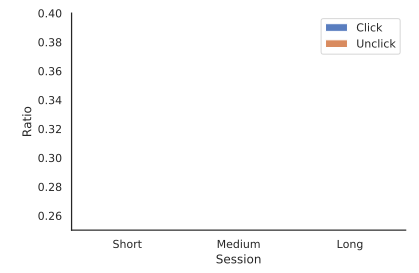

In [21]:

qc_data = [[],[],[]]#short, medium, long
qq_data = [[],[],[]]
for k in result_list:
    for kk in result_list[k]:
        index = 0
        if 3 < k <= 5:
            index = 1
        elif k > 5:
            index = 2           
        qc_data[index].append(np.mean(qc_result_list[k][kk]))
        qq_data[index].append(np.mean(qq_result_list[k][kk]))



df = pd.DataFrame({"Session": ['Short','Medium','Long'],
                   "Unclick": map(lambda l:np.mean(l),qq_data), 
                   "Click": map(lambda l:np.mean(l),qc_data)})
print df

fig, ax = plt.subplots()
tidy = df.melt(id_vars='Session').rename(columns=str.title)

sns.set(style="white")
ax.set(ylim=(0.25, 0.4))
g = sns.barplot(x='Session', y='Value', hue='Variable', data=tidy, ax=ax,
	palette="muted")
sns.despine(fig)


#for index, row in df.iterrows():
#    print index,row
#    #g.text(row.name,row.Value, round(row.total_bill,2), color='black', ha="center")
for p in ax.patches:
	ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()-0.01),
		ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
		textcoords='offset points')
    
# Create a second y-axis with the scaled ticks
ax.legend().set_title('')
ax.set_ylabel('Ratio')
plt.show()

session:  Short
Value:  0.8733909098522413
session:  Medium
Value:  0.9183983424225041
session:  Long
Value:  0.9124303638545647


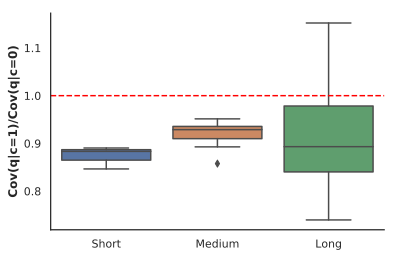

In [37]:
qc_rate_data = {'Session':[],'Value':[]}#short, medium, long
#print qc_rate_in_session

data_list = defaultdict(list)
for k,l_data in qc_rate_in_session.iteritems():
    if k >= 10:
        continue
    index = 'Short'
    if k <= 3:
        index = 'Short'
    elif 3 < k <= 5:
        index = 'Medium'
    elif k < 10:
        index = 'Long'
    for d in l_data:
        qc_rate_data['Session'].append(index)
        qc_rate_data['Value'].append(d)
    
    data_list[index] += l_data

for k,v in data_list.iteritems():
    print 'session: ',k
    print 'Value: ', np.mean(v)
    
#print qc_rate_data

tidy = pd.DataFrame(qc_rate_data)
#print tidy
fig, ax = plt.subplots()
g = sns.boxplot(x='Session', y='Value', data=tidy, ax=ax,showmeans=False)
ax.axhline(1, ls='--',color='red')
ax.set_xlabel('')
ax.set_ylabel('Cov(q|c=1)/Cov(q|c=0)',weight='bold')
sns.despine(fig)

plt.show()

         10         2         3         4         5         6         7  \
0  0.675625  0.846497  0.883328  0.857667  0.928924  0.802501  0.789833   
1  0.976157       NaN  0.890347  0.942141  0.928854  0.869559  0.968456   
2  0.778169       NaN       NaN  0.927084  0.951412  0.896407  1.064154   
3  0.698855       NaN       NaN       NaN  0.892708  0.938859  0.885810   
4  0.974987       NaN       NaN       NaN       NaN  0.925955  1.053609   
5  1.123975       NaN       NaN       NaN       NaN       NaN  0.951775   
6  1.340952       NaN       NaN       NaN       NaN       NaN       NaN   
7  1.351060       NaN       NaN       NaN       NaN       NaN       NaN   
8  2.104401       NaN       NaN       NaN       NaN       NaN       NaN   

          8         9  Session  
0  0.887401  0.859492      2.0  
1  0.889946  0.739713      3.0  
2  1.026459  0.833902      4.0  
3  0.872112  1.152221      5.0  
4  0.769649  1.008696      6.0  
5  0.981593  0.800436      7.0  
6  1.007211  0.807

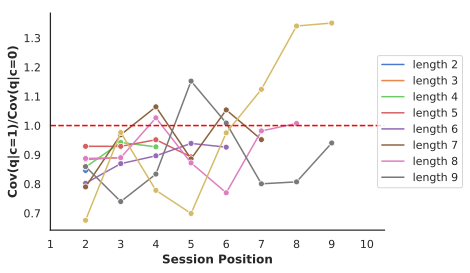

In [105]:
%config InlineBackend.figure_format='svg'
%matplotlib inline

data = qc_rate_in_session
data['Session'] = list(range(2,10))
df = pd.DataFrame(dict([ (str(k),pd.Series(v)) for k,v in data.iteritems() ]))

print df

fig, ax = plt.subplots()
tidy = df.melt(id_vars='Session').rename(columns=str.title)


tidy = tidy.dropna()
#tidy.dropna()
#print tidy

sns.set(style="white")
#ax.set(ylim=(0.6, 1.4))
ax.set(xlim=(1.5, 10.5))

marks = {}
for i,m in enumerate(['o','+','>','^','*','s','v','<','.']):
    marks[str(i+2)] = m
    
#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
g = sns.lineplot(x='Session', y='Value', hue='Variable', data=tidy, ax=ax,hue_order=map(str,range(2,11)),
	palette="muted",marker='o')

sns.despine(fig)

font1 = {
'size'   : 10,
}
#'weight' : 'bold',


# Create a second y-axis with the scaled ticks
#ax.legend(prop=font1).set_title('')
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=handles[1:], labels=labels[1:])
plt.xticks(range(1, 11))
ax.set_xlabel('Session Position',weight='bold')
ax.set_ylabel('Cov(q|c=1)/Cov(q|c=0)',weight='bold')
ax.axhline(1, ls='--',color='red')
labels = ['length '+ str(i) for i in range(1,10)]
g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1,handles=handles[1:], labels=labels[1:])
plt.show()

In [25]:
def checkexist(ent1,ent2,click):
    for e in ent2:
        if e not in ent1 and e in click:
            return 1
    return 0

click_list = [];
result_list = defaultdict(lambda:defaultdict(list))
result_dict = defaultdict(lambda:defaultdict())

for session in tqdm.tqdm(session_data[:]):
    qids = session['qids']
    docs = session['docs']

    entities_lists = map(lambda qid:qid2eid[qid],qids)
    
    session_len = len(docs)
    for i,dids in enumerate(docs[:-1]):
        
        clicks_ents = set()
        for pos,(did,click) in enumerate(dids):
            if click != 0:
                #if session_len == 3 and i == :         
                did_entlist = did2eid[did]
                clicks_ents.update(did_entlist)
        clicks_ents = list(clicks_ents)
        is_exist = checkexist(entities_lists[i],entities_lists[i+1],clicks_ents)
        
        click_list.append(is_exist)
        result_list[session_len][i].append(is_exist)
print 'click exists rate:', np.mean(click_list)


100%|██████████| 89737/89737 [00:01<00:00, 86562.91it/s]

click exists rate: 0.06962978678264559


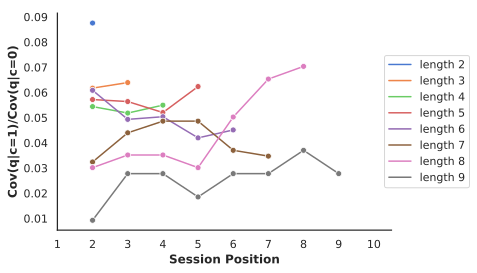

In [248]:
for k in result_list:
    for kk in result_list[k]:
        #result_dict[k][kk] = np.mean(qq_result_list[k][kk])
        result_dict[k][kk] = np.mean(result_list[k][kk])
result = {}
for length in result_dict:
    result[length] = []
    for pos,v in result_dict[length].iteritems():
        if length < 10:
            result[length].append(v)

click_e_in_session = result
print click_e_in_session

%config InlineBackend.figure_format='svg'
%matplotlib inline

data = click_e_in_session
data['Session'] = list(range(2,10))
df = pd.DataFrame(dict([ (str(k),pd.Series(v)) for k,v in data.iteritems() ]))

#print df

fig, ax = plt.subplots()
tidy = df.melt(id_vars='Session').rename(columns=str.title)


tidy = tidy.dropna()
#tidy.dropna()
#print tidy

sns.set(style="white")
#ax.set(ylim=(0.6, 1.4))
ax.set(xlim=(1.5, 10.5))

marks = {}
for i,m in enumerate(['o','+','>','^','*','s','v','<','.']):
    marks[str(i+2)] = m
    
#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
g = sns.lineplot(x='Session', y='Value', hue='Variable', data=tidy, ax=ax,hue_order=map(str,range(2,10)),
	palette="muted",marker='o')

sns.despine(fig)

font1 = {
'size'   : 10,
}
#'weight' : 'bold',


# Create a second y-axis with the scaled ticks
#ax.legend(prop=font1).set_title('')
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=handles[1:], labels=labels[1:])
plt.xticks(range(1, 11))
ax.set_xlabel('Session Position',weight='bold')
ax.set_ylabel('Cov(q|c=1)/Cov(q|c=0)',weight='bold')
#ax.axhline(1, ls='--',color='red')
labels = ['length '+ str(i) for i in range(1,10)]
g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1,handles=handles[1:], labels=labels[1:])
plt.show()

100%|██████████| 89737/89737 [00:00<00:00, 115503.51it/s]


defaultdict(<function <lambda> at 0x7fe1cd394e60>, {2: defaultdict(<function <lambda> at 0x7fe1cd2050c8>, {0: 39583}), 3: defaultdict(<function <lambda> at 0x7fe1cd205938>, {0: 11681, 1: 14645}), 4: defaultdict(<function <lambda> at 0x7fe1cd205b90>, {0: 3973, 1: 4037, 2: 4611}), 5: defaultdict(<function <lambda> at 0x7fe1cd205de8>, {0: 1468, 1: 1522, 2: 1571, 3: 1674}), 6: defaultdict(<function <lambda> at 0x7fe1cd205cf8>, {0: 563, 1: 595, 2: 613, 3: 589, 4: 644}), 7: defaultdict(<function <lambda> at 0x7fe1cd205758>, {0: 259, 1: 279, 2: 277, 3: 270, 4: 274, 5: 291}), 8: defaultdict(<function <lambda> at 0x7fe1cd394578>, {0: 125, 1: 133, 2: 121, 3: 124, 4: 121, 5: 121, 6: 131}), 9: defaultdict(<function <lambda> at 0x7fe1cd098398>, {0: 74, 1: 72, 2: 72, 3: 69, 4: 77, 5: 79, 6: 68, 7: 76}), 10: defaultdict(<function <lambda> at 0x7fe1cd098b90>, {0: 22, 1: 27, 2: 30, 3: 26, 4: 29, 5: 32, 6: 34, 7: 32, 8: 26})})


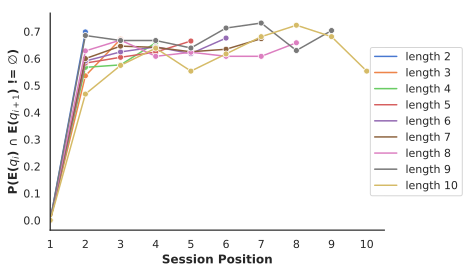

In [73]:
#Useless
%config InlineBackend.figure_format='svg'
%matplotlib inline

result_dict = defaultdict(lambda:defaultdict(lambda:0))
total_dict = defaultdict(lambda:defaultdict(lambda:0))

def checkNew(ent1,ent2):
    for e in ent2:
        if e not in ent1:
            return 1
    return 0

for session in tqdm.tqdm(session_data[:]):
    qids = session['qids']
    docs = session['docs']
    words_lists = map(lambda qid:get_words(qdid2text_dict[qid]),qids)
    entities_lists = map(lambda qid:qid2eid[qid],qids)
    
    #common_words = set.intersection(*map(set, words_lists))
    #common_entities = set.intersection(*map(set, entities_lists))
    session_length = len(qids)
    
    for i in range(len(qids) - 1):        
        common_entities = set.intersection(*map(set, entities_lists[i:i+2]))
        if len(common_entities) > 0:
        #if checkNew(entities_lists[i],entities_lists[i+1]):
            result_dict[session_length][i] += 1
        total_dict[session_length][i] += 1

print result_dict
result = {}
for length in result_dict:
    result[length] = [0]
    for pos,v in result_dict[length].iteritems():
        result[length].append(float(v)/total_dict[length][pos])            
#print result   


max_x = 10
data = result
data['Session'] = list(range(1,max_x+1))
df = pd.DataFrame(dict([ (str(k),pd.Series(v)) for k,v in data.iteritems() ]))

#print df

fig, ax = plt.subplots()
tidy = df.melt(id_vars='Session').rename(columns=str.title)


tidy = tidy.dropna()
#tidy.dropna()
#print tidy

sns.set(style="white")
#ax.set(ylim=(0.6, 1.4))
ax.set(xlim=(1.5, 10.5))

marks = {}
for i,m in enumerate(['o','+','>','^','*','s','v','<','.']):
    marks[str(i+2)] = m
    
#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
g = sns.lineplot(x='Session', y='Value', hue='Variable', data=tidy, ax=ax,hue_order=map(str,range(2,max_x+1)),
	palette="muted",marker='o')

sns.despine(fig)

font1 = {
'size'   : 10,
}
#'weight' : 'bold',


# Create a second y-axis with the scaled ticks
#ax.legend(prop=font1).set_title('')
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=handles[1:], labels=labels[1:])
plt.xticks(range(1, max_x+1))
ax.set_xlabel('Session Position',weight='bold')
ax.set_ylabel('P(E($q_i$) $\cap$ E($q_{i+1}$) != $\emptyset$)',weight='bold')

#ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
#ax.axhline(1, ls='--',color='red')
labels = ['length '+ str(i) for i in range(1,max_x+1)]
g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1,handles=handles[1:], labels=labels[1:])
plt.show()

100%|██████████| 89737/89737 [00:01<00:00, 89157.56it/s]


defaultdict(<function <lambda> at 0x7fe1cd205410>, {2: defaultdict(<function <lambda> at 0x7fe1cc9fbaa0>, {0: 39583}), 3: defaultdict(<function <lambda> at 0x7fe1cc9fb488>, {0: 11681, 1: 14645}), 4: defaultdict(<function <lambda> at 0x7fe1cc9fbde8>, {0: 3973, 1: 4037, 2: 4611}), 5: defaultdict(<function <lambda> at 0x7fe1cc9fba28>, {0: 1468, 1: 1522, 2: 1571, 3: 1674}), 6: defaultdict(<function <lambda> at 0x7fe1cc9fb1b8>, {0: 563, 1: 595, 2: 613, 3: 589, 4: 644}), 7: defaultdict(<function <lambda> at 0x7fe1ccafd1b8>, {0: 259, 1: 279, 2: 277, 3: 270, 4: 274, 5: 291}), 8: defaultdict(<function <lambda> at 0x7fe1ccafd7d0>, {0: 125, 1: 133, 2: 121, 3: 124, 4: 121, 5: 121, 6: 131}), 9: defaultdict(<function <lambda> at 0x7fe1ccafd668>, {0: 74, 1: 72, 2: 72, 3: 69, 4: 77, 5: 79, 6: 68, 7: 76}), 10: defaultdict(<function <lambda> at 0x7fe1ccafd500>, {0: 22, 1: 27, 2: 30, 3: 26, 4: 29, 5: 32, 6: 34, 7: 32, 8: 26})})


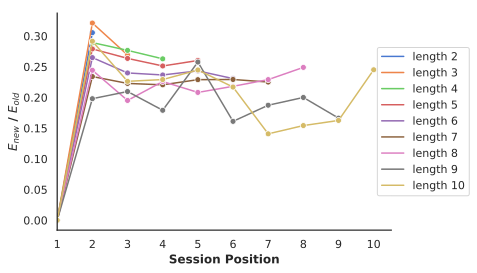

In [80]:
#Useless
%config InlineBackend.figure_format='svg'
%matplotlib inline

result_dict = defaultdict(lambda:defaultdict(lambda:0))
total_dict = defaultdict(lambda:defaultdict(list))

def checkNew(ent1,ent2):
    for e in ent2:
        if e not in ent1:
            return 1
    return 0

for session in tqdm.tqdm(session_data[:]):
    qids = session['qids']
    docs = session['docs']
    words_lists = map(lambda qid:get_words(qdid2text_dict[qid]),qids)
    entities_lists = map(lambda qid:qid2eid[qid],qids)
    
    #common_words = set.intersection(*map(set, words_lists))
    #common_entities = set.intersection(*map(set, entities_lists))
    session_length = len(qids)
    
    for i in range(len(qids) - 1):        
        common_entities = set.intersection(*map(set, entities_lists[i:i+2]))
        if len(common_entities) > 0:
        #if checkNew(entities_lists[i],entities_lists[i+1]):
            result_dict[session_length][i] += 1
        old_rate = float(len(common_entities)) / (len(entities_lists[i+1]) + 1)
        new_rate = float(len(entities_lists[i+1]) - len(common_entities)) / (len(entities_lists[i+1]) + 1)
        total_dict[session_length][i].append(new_rate / (old_rate + 1))

print result_dict
result = {}
for length in result_dict:
    result[length] = [0]
    for pos,v in result_dict[length].iteritems():
        result[length].append(np.mean(total_dict[length][pos]))     
        #result[length].append(float(v)/total_dict[length][pos])            
#print result   


max_x = 10
start = 1
data = result
data['Session'] = list(range(start,max_x+1))
df = pd.DataFrame(dict([ (str(k),pd.Series(v)) for k,v in data.iteritems() ]))

#print df

fig, ax = plt.subplots()
tidy = df.melt(id_vars='Session').rename(columns=str.title)


tidy = tidy.dropna()
#tidy.dropna()
#print tidy

sns.set(style="white")
#ax.set(ylim=(0.6, 1.4))
ax.set(xlim=(1.5, 10.5))

    
#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
g = sns.lineplot(x='Session', y='Value', hue='Variable', data=tidy, ax=ax,hue_order=map(str,range(2,max_x+1)),
 palette="muted",marker='o')

sns.despine(fig)

font1 = {
'size'   : 10,
}
#'weight' : 'bold',


# Create a second y-axis with the scaled ticks
#ax.legend(prop=font1).set_title('')
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=handles[1:], labels=labels[1:])
plt.xticks(range(1, max_x+1))
ax.set_xlabel('Session Position',weight='bold')
ax.set_ylabel('$E_{new}$ / $E_{old}$',weight='bold')

#ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
#ax.axhline(1, ls='--',color='red')
labels = ['length '+ str(i) for i in range(1,max_x+1)]
g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1,handles=handles[1:], labels=labels[1:])
plt.show()